In [215]:
import numpy as np
import pandas as pd

from random import randint
from tqdm.autonotebook import tqdm
from functools import partial

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ML algo
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC

In [221]:
class MLModels():
    model = None
    setting_title = None
    n_trials = 50
    random_state = None
    _columns = None
    coef = 0
    top_pred = None
    pred_var_setting = 0.01
    
    def __init__(self):
        self.training_accuracy = None
        self.test_accuracy = None
        self.training_std = None
        self.test_std = None
        
    def plot_test_train(self):
        fig, ax = plt.subplots()
        ax.plot(self.setting, self.training_accuracy, label="training accuracy")
        ax.plot(self.setting, self.test_accuracy, label="test accuracy")
        ax.fill_between(self.setting, self.training_accuracy-self.training_std, self.training_accuracy+self.training_std, alpha=0.2)
        ax.fill_between(self.setting, self.test_accuracy-self.test_std, self.test_accuracy+self.test_std, alpha=0.2)
        ax.set_ylabel("Accuracy")
        ax.set_xlabel(self.setting_title)
        ax.legend()
        return ax
        
    def calculate_accuracy(self, X, y):
        train_accuracies = []
        test_accuracies = []
        self.setting = sorted(list(set(self.setting).union({self.pred_var_setting})))
        with tqdm(total=self.n_trials*len(self.setting)) as pb:
            for i in range(self.n_trials):
                X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=self.random_state)
                pb.set_description(f'Iter: {i + 1}')
                training_accuracy = []
                test_accuracy = []
                feature_coef = []
                for s in self.setting:
                    # build the model
                    clf = self.model(**{self.setting_title: s})
                    clf.fit(X_train, y_train)
                    # record training set accuracy
                    training_accuracy.append(clf.score(X_train, y_train))
                    # record generalization accuracy
                    test_accuracy.append(clf.score(X_test, y_test))
                    if s == self.pred_var_setting:
                        try:
                            feature_coef.append(clf.coef_)
                        except AttributeError:
                            pass
                    pb.update(1)
                    
                train_accuracies.append(training_accuracy)
                test_accuracies.append(test_accuracy)

        self.training_accuracy = np.mean(train_accuracies, axis=0)
        self.test_accuracy = np.mean(test_accuracies, axis=0)
        self.training_std = np.std(train_accuracies, axis=0)
        self.test_std = np.std(test_accuracies, axis=0)
        if feature_coef:
            self.coef = np.mean(feature_coef, axis=0)
#         return self._best_value(X_train, y_train)
        
#     def _best_value(self, X_train, y_train):
#         best_idx = np.argmax(self.test_accuracy)
#         best_param = self.setting[best_idx]
#         best_model = self.model(**{self.setting_title: best_param})
#         best_model.fit(X_train, y_train)
#         try:
#             self.coef = best_model.coef_
#             self.top_pred = X_train.columns[np.argmax(np.abs(self.coef))]
#         except AttributeError:
#             # model has no ceof_
#             pass
#         return best_model
class KNN(MLModels):
    setting_title = 'n_neighbors'
    pred_var_setting = 1
   
    def __init__(self, neighbor_setting):
        super().__init__()
        self.setting = neighbor_setting
    
class KNNClassifier(KNN):
    model = KNeighborsClassifier

class KNNRegressor(MLModels):
    model = partial(KNeighborsRegressor, algorithm='kd_tree')

class LinearRegressor(MLModels):
    model = None
    setting_title = 'alpha'
    
    def __init__(self, alpha_runs):
        super().__init__()
        self.setting = alpha_runs
        
class LinearClassifier(LinearRegressor):
    model = None
    setting_title = 'C'
    
    def __init__(self, C, reg='l2'):
        self.setting = C
        self._init_model(reg)
        
    def _init_model(self, reg):
        raise NotImplementedError()
        
class LassoRegressor(LinearRegressor):
    model = partial(Lasso, max_iter=10000)
    
class RidgeRegressor(LinearRegressor):
    model = Ridge
    
class LogisticRegressor(LinearClassifier):
    def _init_model(self, reg):
        self.model = partial(LogisticRegression, solver='liblinear', penalty=reg)
        
class LinearSVM(LinearClassifier):
    def _init_model(self, reg):
        self.model = partial(LinearSVC, loss='squared_hinge', dual=False, penalty=reg)

In [108]:
knn = LassoRegressor(alpha)
knn.n_trials = 1
m = knn.calculate_accuracy(df, targets)

/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22055.5360056536, tolerance: 49.91131958247503
  positive)
/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22035.806039720446, tolerance: 49.91131958247503
  positive)
/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20316.64991630728, tolerance: 49.91131958247503
  positive)



1e-08


/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20316.64991630728, tolerance: 49.91131958247503
  positive)


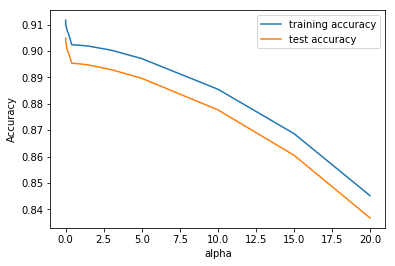

In [111]:
knn.plot_test_train()

In [109]:
knn.top_pred

'Jitter(Abs)'

In [92]:
knn.coef

array([ 4.26456254e-02,  7.26406223e-02, -1.96738007e+00,  2.09893717e-03,
        1.21186701e+00, -1.73736841e+02,  1.36273487e+02,  4.76576879e+01,
       -8.67045254e+01,  1.19428480e+02, -3.34175885e+01,  1.00610542e-01,
        2.43848812e+00,  1.09333304e+02, -4.98340944e+01, -7.50012968e+00,
       -2.34993348e+00, -8.74090130e-02,  3.46876595e+00, -2.54717058e+00,
       -2.14767591e+00])

In [93]:
np.argmax(np.abs(knn.coef))

5

In [90]:
df.columns

Index(['subject#', 'age', 'sex', 'test_time', 'motor_score', 'Jitter(%)',
       'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer',
       'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11',
       'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

In [84]:
dict(knn.coef)

{'subject#': 0.04944182441646096,
 'age': 0.07417937207923817,
 'sex': -1.8289794579196472,
 'test_time': 0.0029854193298086383,
 'motor_score': 1.2049283836165547,
 'Jitter(%)': -339.7533403542714,
 'Jitter(Abs)': 15933.397122439219,
 'Jitter:RAP': -670.6182454516876,
 'Jitter:PPQ5': 139.30421678893708,
 'Jitter:DDP': 362.7527759759615,
 'Shimmer': -63.36490098320458,
 'Shimmer(dB)': 1.5393700827160863,
 'Shimmer:APQ3': -7573.7712260008675,
 'Shimmer:APQ5': 104.46218171505076,
 'Shimmer:APQ11': -36.67182840685512,
 'Shimmer:DDA': 2525.121236656382,
 'NHR': -5.1349841064445485,
 'HNR': -0.08332277565016992,
 'RPDE': 2.5542775669621345,
 'DFA': -2.9065828328670125,
 'PPE': -4.439874240060065}

In [75]:
hasattr()

AttributeError: 'Ridge' object has no attribute 'x'

In [4]:
df = pd.read_excel('parkinsons_updrs.xlsx')

In [5]:
targets = df.loc[:, 'Target']
df.drop('Target', axis=1, inplace=True)

In [13]:
knn = KNNRegressor(range(1, 10, 1))
knn.n_trials = 5

In [14]:
knn.calculate_accuracy(df, targets)

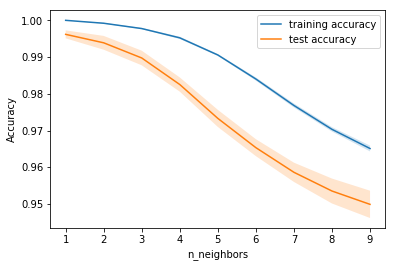

In [15]:
knn.plot_test_train()

In [17]:
alpha = [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20]

In [52]:
lr = LassoRegressor(alpha)
lr.n_trials = 5

In [53]:
lr.calculate_accuracy(df, targets)

/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22636.403810573403, tolerance: 50.72193270122715
  positive)
/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22616.85671827774, tolerance: 50.72193270122715
  positive)
/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20903.878930489514, tolerance: 50.72193270122715
  positive)
/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/Users/edavid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20112.394740117357, tolerance: 49.685989766675526
  positive)


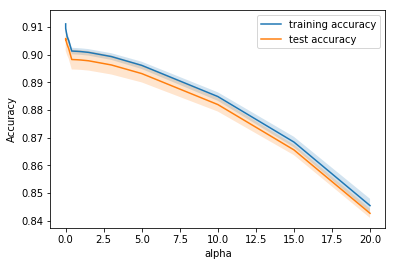

In [54]:
lr.plot_test_train()

In [26]:
rr = RidgeRegressor(alpha)
rr.n_trials = 5

In [30]:
rr.calculate_accuracy(df, targets)

In [180]:
{1}.union({2})

{1, 2}

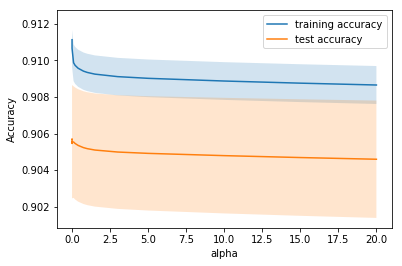

In [31]:
rr.plot_test_train()

In [55]:
rr.model

sklearn.linear_model.ridge.Ridge

In [119]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [202]:
n_nb = list(range(1, 51))

In [211]:
knnc = KNNClassifier(n_nb)

In [213]:
knnc.calculate_accuracy(cancer.data, cancer.target)

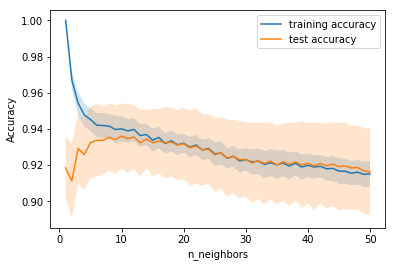

In [214]:
knnc.plot_test_train()

In [114]:
C = [1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]

In [194]:
logr = LogisticRegressor(C)
# logr.n_trials = 2

In [195]:
logr.calculate_accuracy(cancer.data, cancer.target)


[array([[ 0.10924599,  0.02307308,  0.25490251,  0.00148134, -0.00171311,
        -0.01172063, -0.01747529, -0.0069774 , -0.00231528, -0.00030383,
         0.00426035,  0.02195615, -0.01218788, -0.03973397, -0.0002754 ,
        -0.0031984 , -0.00460598, -0.00103441, -0.00067107, -0.00029659,
         0.11886335, -0.11408929, -0.04276553, -0.02388497, -0.00384767,
        -0.03895452, -0.05185174, -0.01392428, -0.00833249, -0.00309533]])]


In [197]:
cancer.feature_names[np.argmax(logr.coef)]

'mean perimeter'

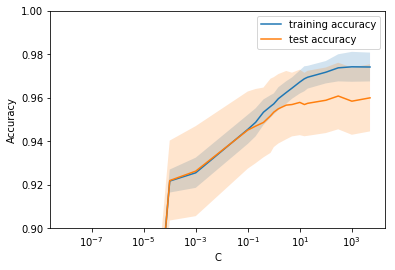

In [156]:
ax = logr.plot_test_train()
ax.set_ylim(0.9, 1)
ax.set_xscale('log')

In [150]:
logr1 = LogisticRegressor(C, 'l1')

In [ ]:
logr1.calculate_accuracy(cancer.data, cancer.target)

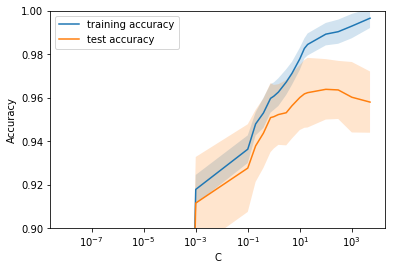

In [155]:
ax = logr1.plot_test_train()
ax.set_ylim(0.9, 1)
ax.set_xscale('log')

In [160]:
np.max(logr1.test_accuracy)

0.9637762237762243

In [161]:
C[np.argmax(logr1.test_accuracy)]

100

In [165]:
cancer.feature_names[np.argmax(logr1.coef)]

'mean compactness'

In [ ]:
svc = LinearSVM(C, 'l1')
svc.calculate_accuracy(cancer.data, cancer.target)

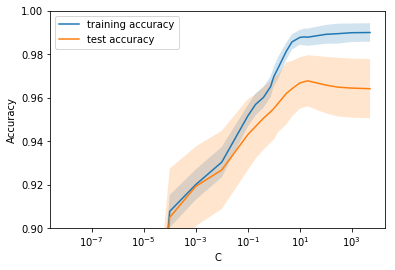

In [224]:
ax = svc.plot_test_train()
ax.set_ylim(0.9, 1)
ax.set_xscale('log')

In [226]:
cancer.feature_names[np.argmax(svc.coef)]

'mean perimeter'